In [22]:
%matplotlib inline
%load_ext jupyternotify
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import krotov
import scipy
import scipy.integrate
import plotly.graph_objects as go
import time
t1 = time.time()

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


## Description of the STIRAP class

In the below cell is the definition for <code>class STIRAP()</code> and it's member functions. All functions which start with an underscore in their name are private and are not meant to be accessed from outside the class. Following is the description of the public member functions and their arguments.

* <code>self.efficiency_of_guess()</code>: The output returned is the efficiency for the current parameter set defining this STIRAP instance.

* <code>self.plot_for_guess(plot_pulses)</code>: here the input is a boolean which if given True will print the graph of the guess pulses of [blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_window) shape. This is set to True by default. This function will show the final plot of the transfer of populations between the states.

* <code>self.krotov_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses of intensity with phase and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Krotov's method](https://qucontrol.github.io/krotov/v1.2.1/07_krotovs_method.html).

* <code>self.scipy_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses (which remain blackman here) and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) on three variables, the end time of the stokes pulse and start time of pump pulse and the two photon detuning ($\delta$).

In [23]:
class STIRAP1():
    def __init__(self,Omega_S,Omega_P,E1,E2,E3,T,tS1,tS2,tP1,tP2,Δ=0,Gamma=0,delta=0,nsteps=500):
        self.Ω_S = Omega_S
        self.Ω_P = Omega_P
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.T = T
        self.tS1 = tS1*T
        self.tS2 = tS2*T
        self.tP1 = tP1*T
        self.tP2 = tP2*T
        self.Δ = Δ - (0.5j*Gamma)
        self.delta = delta
        self.nsteps = nsteps
    
    def _Omega_P1(self,t, args=None):
        return self.Ω_P*krotov.shapes.blackman(t, t_start=self.tP1, t_stop=self.tP2)

    def _Omega_S1(self,t, args=None):
        return self.Ω_S*krotov.shapes.blackman(t, t_start=self.tS1, t_stop=self.tS2)
    
    def _hamiltonian(self,t,i=None,j=None):
        ΔP = self.Δ #E1 + omega_P - E2
        ΔS = -ΔP + self.delta   #E3 + omega_S - E2
        H0 = np.array([[0.0, 0.0, 0.0], [0.0,ΔP, 0.0], [0.0, 0.0,self.delta]])
        HP_re = 0.5*self._Omega_P1(t)*np.array([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HS_re = 0.5*self._Omega_S1(t)*np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
        if i == None and j == None:
            return H0+HP_re+HS_re
        return (H0+HP_re+HS_re)[i,j]
    
    def _final_result(self):
        psi = np.array([1,0,0])
        tlist = np.linspace(0,self.T,self.nsteps)
        psi_list = [psi]
        dt = tlist[1]-tlist[0]
        for i in range(self.nsteps-1):
            psi = np.matmul(scipy.linalg.expm(-1j*dt*self._hamiltonian(tlist[i])),psi_list[-1])
            psi_list.append(psi)
        eff = (np.absolute(psi[2])**2)/(np.absolute(psi[0])**2 + np.absolute(psi[1])**2 + np.absolute(psi[2])**2)
        return np.array(psi_list),tlist,eff
    
    def efficiency_of_guess(self):
        psi = np.array([1,0,0])
        tlist = np.linspace(0,self.T,self.nsteps)
        dt = tlist[1]-tlist[0]
        for i in range(self.nsteps-1):
            psi = np.matmul(scipy.linalg.expm(-1j*dt*self._hamiltonian(tlist[i])),psi)
        eff = (np.absolute(psi[2])**2)/(np.absolute(psi[0])**2 + np.absolute(psi[1])**2 + np.absolute(psi[2])**2)
        return eff
    
    def _neg_eff(self,x):
        self.tS2 = x[0]*self.T
        self.tP1 = x[1]*self.T
        self.delta = x[2]/self.T
        return np.log(1-self.efficiency_of_guess())/np.log(10)
        
    def plot_for_guess(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        psiT,t,_ = self._final_result()
        fig, ax = plt.subplots()
        plt.gcf().set_size_inches(10,5)
        norm = np.absolute(psiT[:,0])**2 + np.absolute(psiT[:,1])**2 + np.absolute(psiT[:,2])**2
        ax.plot(t, np.absolute(psiT[:,0])**2/norm, label='1')
        ax.plot(t, np.absolute(psiT[:,1])**2/norm, label='2')
        ax.plot(t, np.absolute(psiT[:,2])**2/norm, label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, self.nsteps)
        plt.gcf().set_size_inches(10,5)
        pulse = tlist
        if callable(self._Omega_P1) and callable(self._Omega_S1):
            pulse1 = np.array([self._Omega_P1(t, args=None) for t in tlist])
            pulse2 = np.array([self._Omega_S1(t, args=None) for t in tlist])
        plt.plot(tlist, pulse1,label="Pump")
        plt.plot(tlist, pulse2,label="Stokes")
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def scipy_opti_result(self,print_pulse=True,print_results=True):
        opti = scipy.optimize.minimize(self._neg_eff, x0=np.array([self.tS2,self.tP1,self.delta*self.T]), args=(), method='Powell', #bounds = [(0.1,1),(0,0.9),(-40,40)],
                                       options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10, 'disp': True})
        if print_results:
            print(opti)
        self.tS2 = opti.x[0]*self.T
        self.tP1 = opti.x[1]*self.T
        if print_pulse:
            self.plot_for_guess()
            
    def robustness(self,error=0.01):
        run = STIRAP1(Omega_S=self.Ω_S,Omega_P=self.Ω_P,E1=self.E1,E2=self.E2,E3=self.E3,T=self.T,tS1=self.tS1/self.T,tS2=self.tS2/self.T,
                      tP1=self.tP1/self.T,tP2=self.tP2/self.T,Δ=self.Δ.real,Gamma=-2*self.Δ.imag,delta=self.delta,nsteps=self.nsteps)
        deff = [1,1,1,1,1]
        run.Ω_S = (1 + error)*self.Ω_S
        plus = run.efficiency_of_guess()
        run.Ω_S = (1 - error)*self.Ω_S
        minus = run.efficiency_of_guess()
        deff[0] = (plus - minus)/(2*error)
        run.Ω_S = self.Ω_S
        print(plus,minus)
        ################################
        run.Ω_P = (1 + error)*self.Ω_P
        plus = run.efficiency_of_guess()
        run.Ω_P = (1 - error)*self.Ω_P
        minus = run.efficiency_of_guess()
        deff[1] = (plus - minus)/(2*error)
        run.Ω_P = self.Ω_P
        print(plus,minus)
        ################################
        run.Δ = (1 + error)*self.Δ.real + self.Δ.imag
        plus = run.efficiency_of_guess()
        run.Δ = (1 - error)*self.Δ.real + self.Δ.imag
        minus = run.efficiency_of_guess()
        deff[2] = (plus - minus)/(2*error)
        run.Δ = self.Δ
        print(plus,minus)
        ################################
        run.delta = (1 + error)*self.delta
        plus = run.efficiency_of_guess()
        run.delta = (1 - error)*self.delta
        minus = run.efficiency_of_guess()
        deff[3] = (plus - minus)/(2*error)
        run.delta = self.delta
        print(plus,minus)
        ################################
        run.T = (1 + error)*self.T
        plus = run.efficiency_of_guess()
        run.T = (1 - error)*self.T
        minus = run.efficiency_of_guess()
        deff[4] = (plus - minus)/(2*error)
        run.delta = self.delta
        print(plus,minus)
        ################################
        robust = (deff[0]**2 + deff[1]**2 + deff[2]**2 + deff[3]**2 + deff[4]**2)**0.5
        return robust

In [24]:
class cavity_STIRAP():
    def __init__(self,Omega_T,g,E1,E2,E3,T,t0,tg0,t1,tg1,Δ1=0,gamma=0,Δ2=0,kappa=0,nsteps=500):
        self.Ω_T = Omega_T
        self.g = g
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.T = T
        self.t0 = t0*T
        self.t1 = t1*T
        self.tg0 = tg0*T
        self.tg1 = tg1*T
        self.kappa = kappa
        self.Δ1 = Δ1 - 0.5j*gamma
        self.Δ2 = Δ2
        self.nsteps = nsteps
    
    def _Omega_T(self,t,args):
        return self.Ω_T*krotov.shapes.blackman(t, t_start=self.t0, t_stop=self.t1)
    
    def _g(self,t,args):
        return self.g*krotov.shapes.blackman(t, t_start=self.tg0, t_stop=self.tg1)
    
    def _hamiltonian(self):
        H0 = tensor(Qobj([[0.0, 0.0, 0.0], [0.0,self.Δ1, 0.0], [0.0, 0.0,self.Δ2]]),qeye(4)) 
        HP_re = tensor(Qobj([[0.0, 0.5, 0.0], [0.5, 0.0, 0.0], [0.0, 0.0, 0.0]]),qeye(4))
        HS_re = tensor(Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0]]),create(4)) + tensor(Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]),destroy(4))
        return [H0,[HP_re, self._Omega_T],[HS_re, self._g]]
    
    def _final_result(self):
        psi0 = tensor(fock(3,0),fock(4,0))
        kets = [Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        a = tensor(qeye(3),destroy(4))
        e_op_list = [tensor(ket2dm(ket),qeye(4)) for ket in kets] + [a.dag() * a]
        tlist = np.linspace(0,self.T,self.nsteps)
        H = self._hamiltonian()
        c_op_list = [np.sqrt(self.kappa)*a]
        output = mesolve(H, psi0, tlist, c_op_list, e_op_list)
        eff = output.expect[2][-1]
        return output,eff
    
    def efficiency_of_guess(self):
        return self._final_result[1]
    
    def _neg_eff(self,x):
        self.tS2 = x[0]*self.T
        self.tP1 = x[1]*self.T
        self.delta = x[2]/self.T
        return -1*self.efficiency_of_guess()
    
    def _plot_emmision(self,da,t):
        plt.gcf().set_size_inches(7.5,4.2)
        plt.plot(t, da*10**(-6), label='Emmision rate')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Emmision rate (1/$\mu s$)')
        plt.show()
        
    def plot_for_guess(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        result,_ = self._final_result()
        plt.gcf().set_size_inches(7.5,4.2)
        plt.plot(result.times, result.expect[0], label='1')
        plt.plot(result.times, result.expect[1], label='2')
        plt.plot(result.times, result.expect[2], label='3')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.show()
        self._plot_emmision(result.expect[3]*2*self.kappa,result.times)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, self.nsteps)
        pulse = tlist
        if callable(self._Omega_T) and callable(self._g):
            pulse1 = np.array([self._Omega_T(t,args=None) for t in tlist])
            pulse2 = np.array([2*self._g(t,args=None) for t in tlist])
        plt.gcf().set_size_inches(7.5,4.2)
        plt.plot(tlist*(10**6), pulse1/(10**6),label="$\Omega_T(t)$")
        plt.plot(tlist*(10**6), pulse2/(10**6),label="2g(t)")
        plt.xlabel('Time (in $\mu s$)')
        plt.ylabel('Pulse amplitude (in MHz)')
        plt.legend()
        plt.show()

### Example 1
Below is the simulation with both pulses having peak of 31.6 MHz and full overlap over a width of 20 $\mu s$. The single photon detuning is $\Delta = 1$ GHz and there is two photon resonance.

Efficiency = nan


F:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


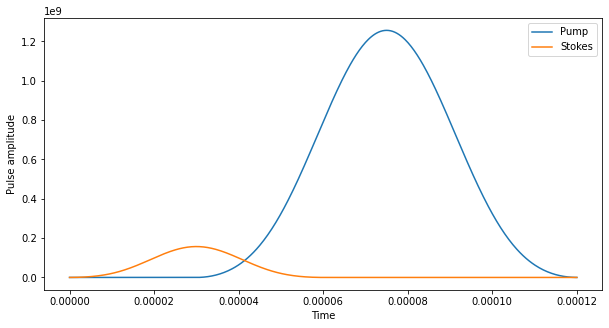

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


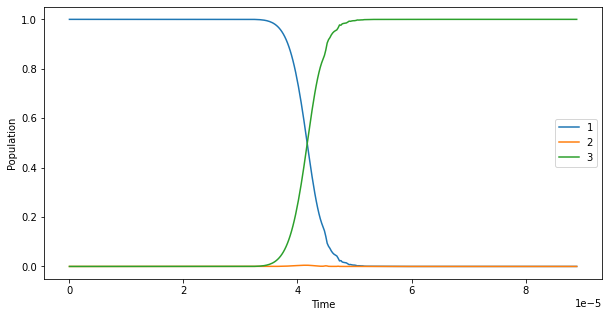

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


nan nan
nan nan
0.0 0.0
nan nan
nan nan
nan


In [20]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
try_1 = STIRAP1(Omega_S=2*np.pi*25*10**6,Omega_P=2*np.pi*200*10**6,E1=0,E2=hfs,E3=F_3,T=120*10**(-6),tS1=0,tS2=0.5,tP1=0.25,tP2=1,Δ=0*10**9,delta = -1j*np.pi*2.5*10**6,Gamma=2*np.pi*6*10**6)
print("Efficiency = "+str(try_1.efficiency_of_guess()))
try_1.plot_for_guess()
print(try_1.robustness())

Optimization terminated successfully.
         Current function value: -2.292514
         Iterations: 5
         Function evaluations: 199
   direc: array([[ 8.91443902e-02,  1.16541442e-01,  1.01390542e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 7.97145026e-04, -1.63064376e-05,  3.50379341e-03]])
     fun: -2.2925138580734843
 message: 'Optimization terminated successfully.'
    nfev: 199
     nit: 5
  status: 0
 success: True
       x: array([ 1.21424479,  0.17169628, 54.65548381])


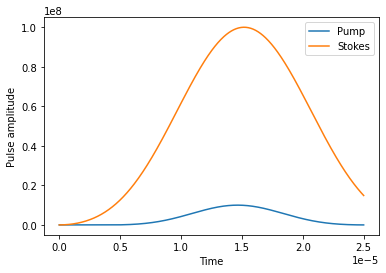

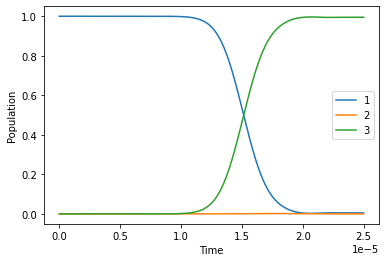

AttributeError: 'STIRAP1' object has no attribute 'efficiency'

In [100]:
try_2 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=2.5*10**(-5),tS1=0,tS2=0.8,tP1=0.14,tP2=1,Δ=10**9,delta=2.088*10**6)
try_2.scipy_opti_result()
print("Efficiency = "+str(try_2.efficiency()))
print("Robustness = "+str(try_2.robustness()))

Efficiency = 7.335586218210714e-05
   direc: array([[ 5.04220923e-03, -8.98612489e-03, -4.33396307e-01],
       [ 5.86182784e-02, -1.48720821e-02, -6.36935995e-01],
       [ 7.86458976e-03, -5.31607876e-04,  1.59107839e-02]])
     fun: -0.737547197269743
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 434
     nit: 10
  status: 2
 success: False
       x: array([6.53202946, 0.01707359, 6.58961667])


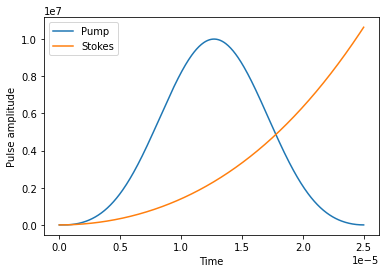

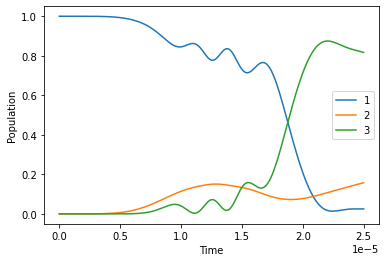

Robustness = 2094606.8759066027


In [120]:
try_2 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=2.5*10**(-5),tS1=0,tS2=1.21424479,tP1=0.17169628,tP2=1,Δ=1*10**7,delta=54.65548381/(2.5*10**(-5)))
print("Efficiency = "+str(try_2.efficiency_of_guess()))
try_2.scipy_opti_result()
print("Robustness = "+str(try_2.robustness(0.00000001)))
#4942527.457573466
#49425273.02473101

Efficiency = 0.9947146376700357


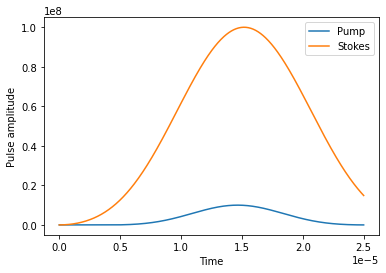

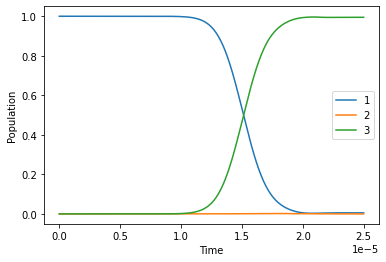

0.9818181007777996 0.9857959446102992
0.996523621657816 0.9924777048646539
0.9916535451271196 0.9918207084689535
0.9937492369342269 0.9910665315773375
0.994684180051267 0.9946586201783949


0.3139195325827287

In [14]:
try_2 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=2.5*10**(-5),tS1=0,tS2=1.21424479,tP1=0.17169628,tP2=1,Δ=10**9,delta=2.18*10**6)
print("Efficiency = "+str(try_2.efficiency_of_guess()))
try_2.plot_for_guess()
try_2.robustness()

In [46]:
points = 100
x_range = np.linspace(0.5,1,points)
y_range = np.linspace(-0.3,0.3,points)
X,Y = np.meshgrid(x_range, y_range)
Z = [[-1 for i in range(points)] for j in range(points)]
for i in range(len(Y)):
    for j in range(len(X)):
        try_4 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=32*10**(-6),tS1=0,tS2=x_range[j],tP1=y_range[i],tP2=1,Δ=10**9,delta=2109043.1553125)
        Z[i][j] = try_4.efficiency_of_guess()
    print("Progress\t"+str(i)+"/"+str(points)+"\t Last: "+str(Z[i][j]))
Z = np.array(Z)

Progress	0/100	 Last: 0.9804929274764829
Progress	1/100	 Last: 0.98234748713458
Progress	2/100	 Last: 0.9840474383506945
Progress	3/100	 Last: 0.9855925202676734
Progress	4/100	 Last: 0.9869827384500137
Progress	5/100	 Last: 0.9882183766413716
Progress	6/100	 Last: 0.9893000084750788
Progress	7/100	 Last: 0.9902285090988773
Progress	8/100	 Last: 0.9910050666716426
Progress	9/100	 Last: 0.9916311936860168
Progress	10/100	 Last: 0.9921087380663818
Progress	11/100	 Last: 0.9924398939870082
Progress	12/100	 Last: 0.9926272123497741
Progress	13/100	 Last: 0.9926736108550898
Progress	14/100	 Last: 0.9925823835931387
Progress	15/100	 Last: 0.9923572100753529
Progress	16/100	 Last: 0.9920021636181013
Progress	17/100	 Last: 0.9915217189817174
Progress	18/100	 Last: 0.9909207591583425
Progress	19/100	 Last: 0.9902045811912931
Progress	20/100	 Last: 0.989378900896806
Progress	21/100	 Last: 0.988449856346231
Progress	22/100	 Last: 0.9874240099524695
Progress	23/100	 Last: 0.9863083489890604
Progre

In [47]:
np.save("eff_better_32.npy",Z)

In [15]:
times = np.linspace(1,100,20)
effi_T = []
robusts = []
for T in times:
    print("============================"+str(T)+"=========================")
    try_5 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=T*10**(-6),tS1=0,tS2=0.9,tP1=0.4,tP2=1,Δ=10**9,delta=2*10**6)
    try_5.scipy_opti_result(False)
    effi_T.append(try_5.efficiency_of_guess())
    robusts.append(try_5.robustness())

============================1.0=========================
Optimization terminated successfully.
         Current function value: -0.002665
         Iterations: 4
         Function evaluations: 153
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.51522439e-02,  7.32934510e-04,  3.86689747e-03],
       [-4.25609216e-03, -6.30770353e-03, -1.22842833e-02]])
     fun: -0.0026645662581951273
 message: 'Optimization terminated successfully.'
    nfev: 153
     nit: 4
  status: 0
 success: True
       x: array([ 1.06301135, -0.06254808,  1.80531851])
0.0062383810808750205 0.0059957483932589145
0.006239291637519737 0.005995133944914265
0.005996779123742122 0.00624001576002103
0.006116576122527888 0.006116576088034136
0.006116618305875983 0.006116618142413094
============================6.2105263157894735=========================
Optimization terminated successfully.
         Current function value: -0.098668
         Iterations: 4
         Function evaluations: 14

   direc: array([[-1.79139470e-02,  1.03015167e-02, -2.48126786e-01],
       [-2.72065852e-02, -1.46411524e-02, -4.40630066e-01],
       [-4.79331264e-03, -1.36020086e-04, -9.07406525e-02]])
     fun: -3.8402090113366434
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 423
     nit: 10
  status: 2
 success: False
       x: array([  1.2693991 ,   0.23797443, 108.2436617 ])
0.9142955733676332 0.9178664470609157
0.9993868753424727 0.999252767726458
0.9758198545925846 0.9758499708184843
0.9859244570727608 0.9866847377699464
0.9998783627438587 0.9998303309686083
============================63.526315789473685=========================
   direc: array([[-1.52637517e-02,  2.89139737e-03, -2.83361382e-01],
       [-9.30835457e-03, -3.27496935e-03, -1.16301989e-01],
       [-1.91514653e-02, -1.87320869e-04, -4.52634922e-01]])
     fun: -3.6203178446819497
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 431
     nit: 10
  status: 2
 success: False
       

Text(0, 0.5, '$-\\log_{10} (1-$efficiency)')

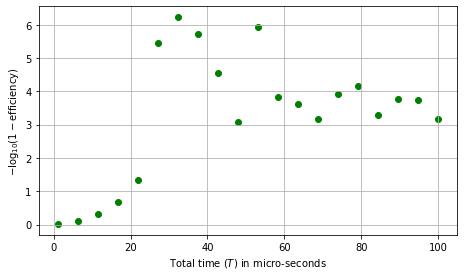

In [33]:
effi_T = np.array(effi_T)
def eff_interpolated(x,V,C):
    x_points = V
    y_points = C
    tck = scipy.interpolate.splrep(x_points, y_points)
    return scipy.interpolate.splev(x, tck)
x_times = np.linspace(1,100,1000)
logs = eff_interpolated(x_times,times,-np.log(1-effi_T)/np.log(10))


fig, ax = plt.subplots()
plt.gcf().set_size_inches(7.5,4.2)
# %matplotlib inline
ax.scatter(times,-np.log(1-effi_T)/np.log(10),color='g')
#ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('$-\log_{10} (1-$efficiency)')

[0.0210741346908093, 0.6082292287730171, 1.165744859289204, 1.2550091902115306, 0.7752948115814831, 0.04161361295207467, 0.03887809370042186, 0.04526722066558853, 0.04974799859152755, 0.031666139992366615, 0.22117385437957976, 0.1826907534815257, 0.2275908667463279, 0.39659790831141173, 0.16836541398568183, 0.08862289923070953, 0.10648936352616463, 0.03312660920370625, 0.021167939033498666, 0.23600613079863025]


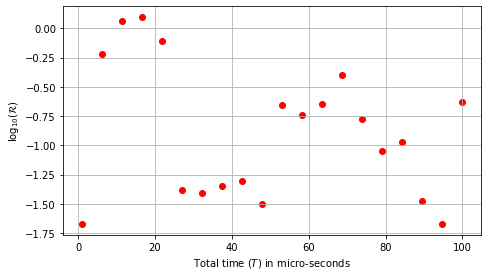

In [36]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches(7.5,4.2)
# %matplotlib inline
ax.scatter(times,np.log(np.array(robusts))/np.log(10),color='r')
# ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('$\log_{10}(\mathcal{R}$)')
print(robusts)

In [20]:
for i in range(20):
    print("Times: "+str(times[i])+" Eff: "+str(effi_T[i])+" Rob:"+str(robusts[i]))

Times: 1.0 Eff: 0.006116607470308695 Rob:0.0210741346908093
Times: 6.2105263157894735 Eff: 0.20323236686412807 Rob:0.6082292287730171
Times: 11.421052631578947 Eff: 0.5158413737491481 Rob:1.165744859289204
Times: 16.63157894736842 Eff: 0.785749726933112 Rob:1.2550091902115306
Times: 21.842105263157894 Eff: 0.9524737395894717 Rob:0.7752948115814831
Times: 27.052631578947366 Eff: 0.9999964177603039 Rob:0.04161361295207467
Times: 32.26315789473684 Eff: 0.9999994224151892 Rob:0.03887809370042186
Times: 37.473684210526315 Eff: 0.9999981554145904 Rob:0.04526722066558853
Times: 42.68421052631579 Eff: 0.9999725054470956 Rob:0.04974799859152755
Times: 47.89473684210526 Eff: 0.9991504337720803 Rob:0.031666139992366615
Times: 53.10526315789473 Eff: 0.9999988113268362 Rob:0.22117385437957976
Times: 58.315789473684205 Eff: 0.9998559563446776 Rob:0.1826907534815257
Times: 63.526315789473685 Eff: 0.9997591585359193 Rob:0.2275908667463279
Times: 68.73684210526315 Eff: 0.9993400393129748 Rob:0.39659790

Optimization terminated successfully.
         Current function value: -6.371518
         Iterations: 5
         Function evaluations: 244
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-4.15612132e-04,  2.64230130e-02,  8.14022218e-02]])
     fun: -6.371517681389278
 message: 'Optimization terminated successfully.'
    nfev: 244
     nit: 5
  status: 0
 success: True
       x: array([ 0.84596267, -0.20130628, 67.48938097])


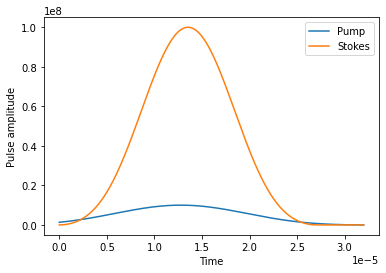

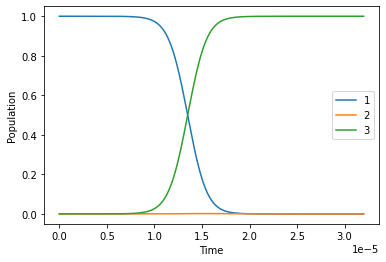

0.9889842848036462 0.9897307063332813
0.9997768382876787 0.9997770504733614
0.9972064723223717 0.9970124189257124
0.9979312882552226 0.997860877395955
0.9999995765174721 0.9999995740986956
0.03872207234863813
0.9999995749085455


In [21]:
try_5 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=32*10**(-6),tS1=0,tS2=0.9,tP1=0.4,tP2=1,Δ=10**9,delta=2*10**6)
try_5.scipy_opti_result()
print(try_5.robustness())
print(try_5.efficiency_of_guess())

In [38]:
67.48938097/(32*10**(-6))

2109043.1553125

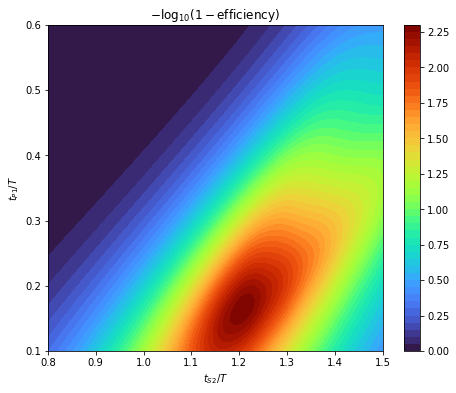

In [37]:
Z1 = np.load("eff_better.npy")
sh_0, sh_1 = Z1.shape
X1, Y1 = np.linspace(0.8, 1.5, sh_0), np.linspace(0.1, 0.6, sh_1)
plt.gcf().set_size_inches(7.5,6)
plt.xlabel("$t_{S2}/T$")
plt.ylabel("$t_{P1}/T$")
plt.title("$-\log_{10}(1-$efficiency$)$")
plt.contourf(X1, Y1, -np.log(1-Z1)/np.log(10), 50, cmap='turbo')
plt.colorbar();
# fig = go.Figure(data=[go.Surface(z=Z1, x=X1, y=Y1)])
# fig.update_layout(title='Variation of efficiencies',#autosize=False,
#                   width=1000, height=700,
#                   margin=dict(l=65, r=50, b=65, t=90)
#                  )
# fig.show()

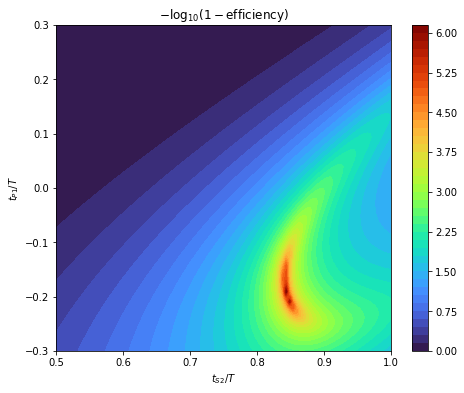

In [51]:
Z1 = np.load("eff_better_32.npy")
sh_0, sh_1 = Z1.shape
X1, Y1 = np.linspace(0.5, 1, sh_0), np.linspace(-0.3, 0.3, sh_1)
plt.gcf().set_size_inches(7.5,6)
plt.xlabel("$t_{S2}/T$")
plt.ylabel("$t_{P1}/T$")
plt.title("$-\log_{10}(1-$efficiency$)$")
plt.contourf(X1, Y1, -np.log(1-Z1)/np.log(10), 50, cmap='turbo')
plt.colorbar();
fig = go.Figure(data=[go.Surface(z=-np.log(1-Z1), x=X1, y=Y1)])
fig.update_layout(title='Variation of efficiencies',#autosize=False,
                  width=1000, height=700,
                  margin=dict(l=65, r=50, b=65, t=90)
                 )
fig.show()

In [67]:
times = np.linspace(1,100,20)
effi_T0 = []
robusts0 = []
for T in times:
    print("============================"+str(T)+"=========================")
    try_5 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=T*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**9,delta=0)
    try_5.scipy_opti_result(False)
    effi_T0.append(try_5.efficiency_of_guess())
    robusts0.append(try_5.robustness())

============================1.0=========================
Optimization terminated successfully.
         Current function value: -0.002666
         Iterations: 4
         Function evaluations: 175
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.62167859e-02,  7.90385565e-04, -9.20594874e-04],
       [-4.05598904e-03, -6.03149386e-03, -2.43280956e-03]])
     fun: -0.0026657202358179393
 message: 'Optimization terminated successfully.'
    nfev: 175
     nit: 4
  status: 0
 success: True
       x: array([ 1.06319057, -0.06311538,  0.03150405])
============================6.2105263157894735=========================
Optimization terminated successfully.
         Current function value: -0.106949
         Iterations: 4
         Function evaluations: 154
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.56752337e-02,  7.61059984e-04, -8.52871395e-04],
       [-4.19058329e-03, -6.18468773e-03, -1.04999241e-02]])
     fun: -0.10694

============================84.36842105263158=========================
Optimization terminated successfully.
         Current function value: -3.630967
         Iterations: 4
         Function evaluations: 165
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-4.94455698e-04,  5.99871580e-06,  2.01382147e-03]])
     fun: -3.630967231094682
 message: 'Optimization terminated successfully.'
    nfev: 165
     nit: 4
  status: 0
 success: True
       x: array([ 1.72930397, -0.13880542,  2.1882748 ])
============================89.57894736842105=========================
Optimization terminated successfully.
         Current function value: -3.728573
         Iterations: 8
         Function evaluations: 328
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.42866230e-03, -1.34538430e-04,  3.62770984e-03],
       [-1.35928495e-02, -1.02716664e-02,  1.65750707e-02]])
     fun:

In [49]:
t2 = time.time()
print(t2-t1)
%notify -m "Check the notebook"

16332.452449321747


<IPython.core.display.Javascript object>

Text(0, 0.5, 'Robustness')

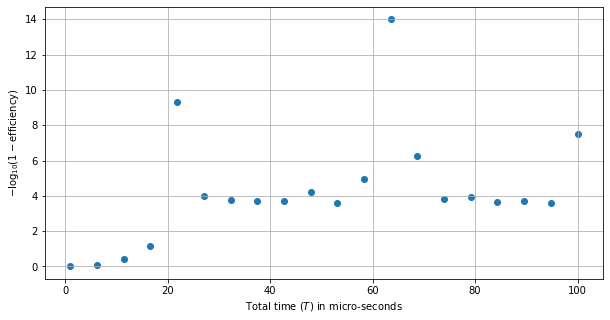

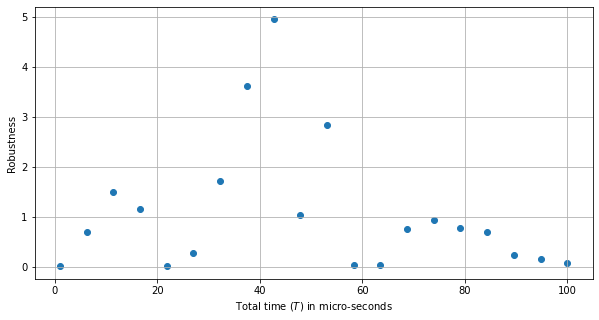

In [70]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
# %matplotlib inline
ax.scatter(times,-np.log(1-np.array(effi_T0))/np.log(10))
# ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('$-\log_{10} (1-$efficiency)')
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
# %matplotlib inline
ax.scatter(times,robusts0)
# ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('Robustness')

0.9947034893748468


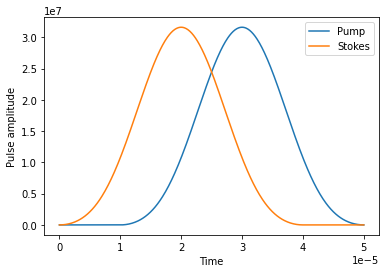

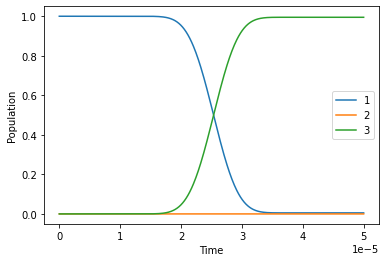

0.2461510389744988


In [82]:
try_6 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=50*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**9,delta=0)
# try_6.scipy_opti_result(True)
print(try_6.efficiency_of_guess())
try_6.plot_for_guess()
print(try_6.robustness())

0.9994726602230813


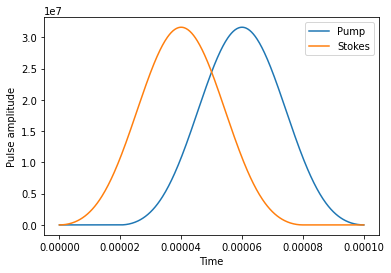

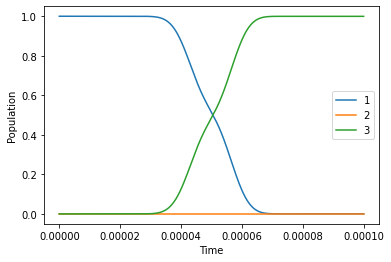

0.07577478120701191


In [86]:
try_7 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=100*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**9,delta=0)
# try_6.scipy_opti_result(True)
print(try_7.efficiency_of_guess())
try_7.plot_for_guess()
print(try_7.robustness())

0.9999999002450578


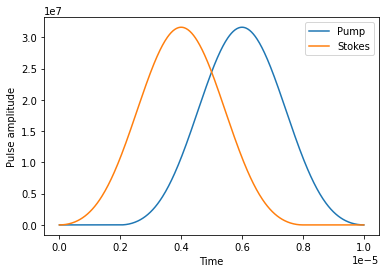

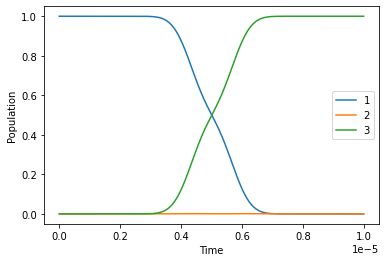

0.0009067205073409492


In [88]:
try_7 = STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=10*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**8,delta=0)
# try_6.scipy_opti_result(True)
print(try_7.efficiency_of_guess())
try_7.plot_for_guess()
print(try_7.robustness())

0.3058324707655031


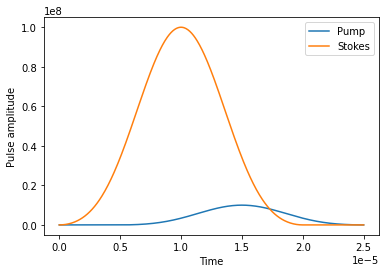

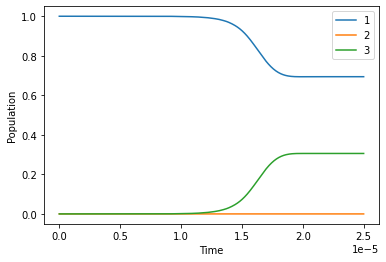

0.5863482366501136


In [94]:
try_8 = STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=25*10**(-6),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**8,delta=0)
# try_8.scipy_opti_result(True)
print(try_8.efficiency_of_guess())
try_8.plot_for_guess()
print(try_8.robustness())

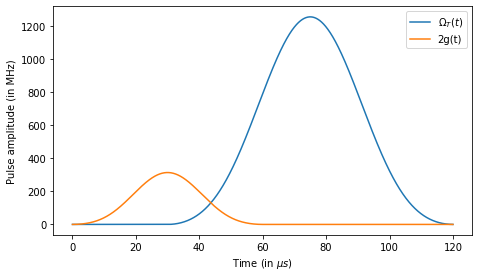

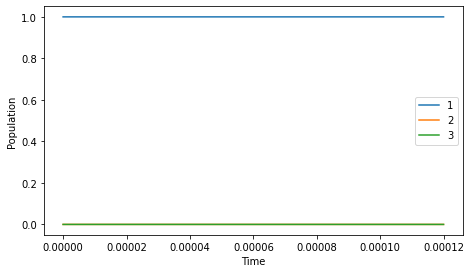

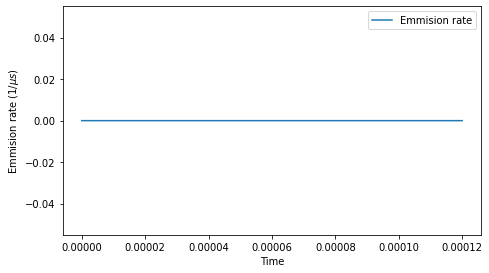

In [21]:
cavity1 = cavity_STIRAP(Omega_T = 2*np.pi*200*(10**6),g = 2*np.pi*25*(10**6),E1=0,E2=hfs,E3=F_3,T=120*(10**(-6)),t0=0.25,tg0=0,t1=1,tg1=0.5,Δ1=0,gamma=2*np.pi*6*(10**6),Δ2=0,kappa=np.pi*2.5*(10**6),nsteps=10000)
cavity1.plot_for_guess()

In [9]:
list(np.array([1]))

[1]

In [16]:
np.array(create(4))

array([[0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [1.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 1.41421356+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 1.73205081+0.j, 0.        +0.j]])

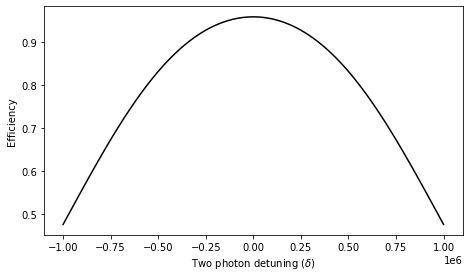

In [29]:
#Δ=0
T=5*10**(-5)
deltavalues=np.linspace(-10**6, 10**6, 100)
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
xvalues=deltavalues
yvalues=[]
for i in deltavalues:
    trial=STIRAP1(Omega_S=31.6*10**6,Omega_P=31.6*10**5,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=0,delta=i)
    e = trial.efficiency_of_guess()
    yvalues.append(e)


def eff_interpolated(x,V,C):
    x_points = V
    y_points = C
    tck = scipy.interpolate.splrep(x_points, y_points)
    return scipy.interpolate.splev(x, tck)
deltax=np.linspace(-10**6, 10**6, 1000)
efficiency=eff_interpolated(deltax,xvalues,yvalues)
fig, ax = plt.subplots()

ax.set_xlabel('Two photon detuning ($\delta$)')
ax.set_ylabel('Efficiency')
fig.set_figwidth(7.5)
fig.set_figheight(4.2)
#ax.plot(deltax, efficiency, color="black")
ax.plot(xvalues, yvalues, color="black")
plt.show(fig)

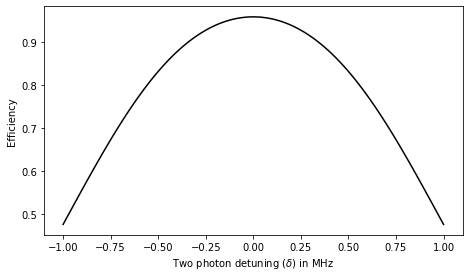

In [30]:
fig, ax = plt.subplots()

ax.set_xlabel('Two photon detuning ($\delta$) in MHz')
ax.set_ylabel('Efficiency')
fig.set_figwidth(7.5)
fig.set_figheight(4.2)
#ax.plot(deltax, efficiency, color="black")
ax.plot(xvalues/10**6, yvalues, color="black")
plt.show(fig)

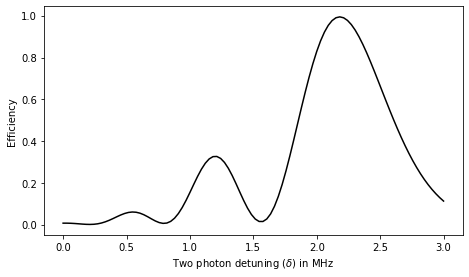

In [31]:
T=25*10**(-6)
deltavalues=np.linspace(0, 3*10**6, 100)
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
xvalues=deltavalues
yvalues=[]
for i in deltavalues:
    trial=STIRAP1(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=25*10**(-6),tS1=0,tS2=1.2,tP1=0.16,tP2=1,Δ=10**9,Gamma=0,delta=i)
    e = trial.efficiency_of_guess()
    yvalues.append(e)

fig, ax = plt.subplots()

ax.set_xlabel('Two photon detuning ($\delta$) in MHz')
ax.set_ylabel('Efficiency')
fig.set_figwidth(7.5)
fig.set_figheight(4.2)
#ax.plot(deltax, efficiency, color="black")
ax.plot(xvalues/10**6, yvalues, color="black")
plt.show(fig)